# Menganalisis Makalah COVID-19

Dalam tantangan ini, kita akan melanjutkan topik pandemi COVID dan berfokus pada pemrosesan makalah ilmiah tentang subjek tersebut. Terdapat [Dataset CORD-19](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge) dengan lebih dari 7000 (pada saat penulisan) makalah tentang COVID, tersedia dengan metadata dan abstrak (dan untuk sekitar setengahnya juga disediakan teks lengkap).

Contoh lengkap analisis dataset ini menggunakan layanan kognitif [Text Analytics for Health](https://docs.microsoft.com/azure/cognitive-services/text-analytics/how-tos/text-analytics-for-health/?WT.mc_id=academic-77958-bethanycheum) dijelaskan [dalam posting blog ini](https://soshnikov.com/science/analyzing-medical-papers-with-azure-and-text-analytics-for-health/). Kita akan membahas versi yang disederhanakan dari analisis ini.


In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Mendapatkan Data

Pertama, kita perlu mendapatkan metadata untuk makalah CORD yang akan kita gunakan.

**NOTE**: Kami tidak menyediakan salinan dataset sebagai bagian dari repositori ini. Anda mungkin perlu mengunduh file [`metadata.csv`](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge?select=metadata.csv) dari [dataset ini di Kaggle](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge). Pendaftaran di Kaggle mungkin diperlukan. Anda juga dapat mengunduh dataset tanpa pendaftaran [dari sini](https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/historical_releases.html), tetapi akan mencakup semua teks lengkap selain file metadata.

Kami akan mencoba mendapatkan data langsung dari sumber online, namun, jika gagal, Anda perlu mengunduh data seperti yang dijelaskan di atas. Selain itu, masuk akal untuk mengunduh data jika Anda berencana untuk bereksperimen lebih lanjut, untuk menghemat waktu tunggu.

> **NOTE** bahwa dataset ini cukup besar, sekitar 1 Gb, dan baris kode berikut dapat memakan waktu lama untuk selesai! (~5 menit)


In [146]:
df = pd.read_csv("https://datascience4beginners.blob.core.windows.net/cord/metadata.csv.zip",compression='zip')
# df = pd.read_csv("metadata.csv")
df.head()

C:\winapp\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning:

Columns (1,4,5,6,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.



cord_uid                                       sha source_x  \
0  ug7v899j  d1aafb70c066a2068b02786f8929fd9c900897fb      PMC   
1  02tnwd4m  6b0567729c2143a66d737eb0a2f63f2dce2e5a7d      PMC   
2  ejv2xln0  06ced00a5fc04215949aa72528f2eeaae1d58927      PMC   
3  2b73a28n  348055649b6b8cf2b9a376498df9bf41f7123605      PMC   
4  9785vg6d  5f48792a5fa08bed9f56016f4981ae2ca6031b32      PMC   

                                               title                    doi  \
0  Clinical features of culture-proven Mycoplasma...  10.1186/1471-2334-1-6   
1  Nitric oxide: a pro-inflammatory mediator in l...           10.1186/rr14   
2    Surfactant protein-D and pulmonary host defense           10.1186/rr19   
3               Role of endothelin-1 in lung disease           10.1186/rr44   
4  Gene expression in epithelial cells in respons...           10.1186/rr61   

      pmcid pubmed_id license  \
0  PMC35282  11472636   no-cc   
1  PMC59543  11667967   no-cc   
2  PMC59549  11667972   no-cc   
3  PMC59574  11686871   no-cc   
4  PMC59580  11686888   no-cc   

                                            abstract publish_time  \
0  OBJECTIVE: This retrospective chart review des...   2001-07-04   
1  Inflammatory diseases of the respiratory tract...   2000-08-15   
2  Surfactant protein-D (SP-D) participates in th...   2000-08-25   
3  Endothelin-1 (ET-1) is a 21 amino acid peptide...   2001-02-22   
4  Respiratory syncytial virus (RSV) and pneumoni...   2001-05-11   

                                             authors         journal  mag_id  \
0                Madani, Tariq A; Al-Ghamdi, Aisha A  BMC Infect Dis     NaN   
1  Vliet, Albert van der; Eiserich, Jason P; Cros...      Respir Res     NaN   
2                                    Crouch, Erika C      Respir Res     NaN   
3  Fagan, Karen A; McMurtry, Ivan F; Rodman, David M      Respir Res     NaN   
4  Domachowske, Joseph B; Bonville, Cynthia A; Ro...      Respir Res     NaN   

  who_covidence_id arxiv_id  \
0              NaN      NaN   
1              NaN      NaN   
2              NaN      NaN   
3              NaN      NaN   
4              NaN      NaN   

                                      pdf_json_files  \
0  document_parses/pdf_json/d1aafb70c066a2068b027...   
1  document_parses/pdf_json/6b0567729c2143a66d737...   
2  document_parses/pdf_json/06ced00a5fc04215949aa...   
3  document_parses/pdf_json/348055649b6b8cf2b9a37...   
4  document_parses/pdf_json/5f48792a5fa08bed9f560...   

                               pmc_json_files  \
0  document_parses/pmc_json/PMC35282.xml.json   
1  document_parses/pmc_json/PMC59543.xml.json   
2  document_parses/pmc_json/PMC59549.xml.json   
3  document_parses/pmc_json/PMC59574.xml.json   
4  document_parses/pmc_json/PMC59580.xml.json   

                                                 url  s2_id  
0  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...    NaN  
1  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
2  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
3  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
4  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN

Kami sekarang akan mengubah kolom tanggal publikasi menjadi `datetime`, dan membuat histogram untuk melihat rentang tanggal publikasi.


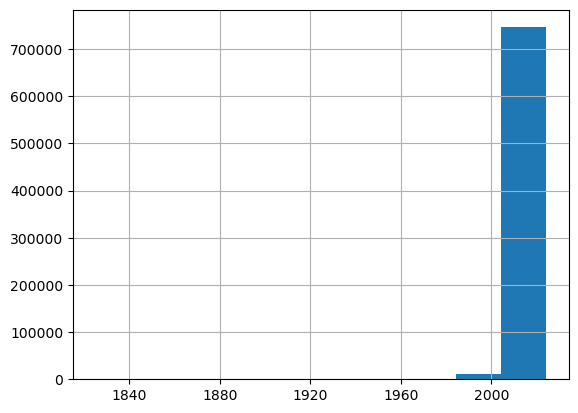

In [147]:
df['publish_time'] = pd.to_datetime(df['publish_time'])
df['publish_time'].hist()
plt.show()

## Ekstraksi Data Terstruktur

Mari kita lihat jenis informasi apa yang dapat kita ekstrak dengan mudah dari abstrak. Salah satu hal yang mungkin menarik adalah melihat strategi pengobatan apa saja yang ada, dan bagaimana strategi tersebut berkembang seiring waktu. Sebagai langkah awal, kita dapat secara manual menyusun daftar kemungkinan obat yang digunakan untuk mengobati COVID, serta daftar diagnosis. Setelah itu, kita meninjau daftar tersebut dan mencari istilah yang sesuai dalam abstrak makalah.


In [148]:
medications = [
    'hydroxychloroquine', 'chloroquine', 'tocilizumab', 'remdesivir', 'azithromycin', 
    'lopinavir', 'ritonavir', 'dexamethasone', 'heparin', 'favipiravir', 'methylprednisolone']
diagnosis = [
    'covid','sars','pneumonia','infection','diabetes','coronavirus','death'
]

for m in medications:
    print(f" + Processing medication: {m}")
    df[m] = df['abstract'].apply(lambda x: str(x).lower().count(' '+m))
    
for m in diagnosis:
    print(f" + Processing diagnosis: {m}")
    df[m] = df['abstract'].apply(lambda x: str(x).lower().count(' '+m))

 + Processing medication: hydroxychloroquine
 + Processing medication: chloroquine
 + Processing medication: tocilizumab
 + Processing medication: remdesivir
 + Processing medication: azithromycin
 + Processing medication: lopinavir
 + Processing medication: ritonavir
 + Processing medication: dexamethasone
 + Processing medication: heparin
 + Processing medication: favipiravir
 + Processing medication: methylprednisolone
 + Processing diagnosis: covid
 + Processing diagnosis: sars
 + Processing diagnosis: pneumonia
 + Processing diagnosis: infection
 + Processing diagnosis: diabetes
 + Processing diagnosis: coronavirus
 + Processing diagnosis: death


Kami telah menambahkan sejumlah kolom ke dataframe kami yang berisi jumlah kemunculan obat/diagnosis tertentu dalam abstrak.

> **Catatan** bahwa kami menambahkan spasi di awal kata saat mencari substring. Jika tidak, kami mungkin mendapatkan hasil yang salah, karena *chloroquine* juga akan ditemukan di dalam substring *hydroxychloroquine*. Selain itu, kami memaksa konversi kolom abstrak menjadi `str` untuk menghindari kesalahan - coba hapus `str` dan lihat apa yang terjadi.

Untuk mempermudah bekerja dengan data, kita dapat mengekstrak sub-frame yang hanya berisi jumlah obat, dan menghitung jumlah total kemunculannya. Ini akan memberikan kita obat yang paling populer:


In [149]:
dfm = df[medications]
dfm = dfm.sum().reset_index().rename(columns={ 'index' : 'Name', 0 : 'Count'})
dfm.sort_values('Count',ascending=False)

Name  Count
0   hydroxychloroquine   9806
3           remdesivir   7861
2          tocilizumab   6118
1          chloroquine   4578
8              heparin   4161
5            lopinavir   3811
4         azithromycin   3585
7        dexamethasone   3340
9          favipiravir   2439
10  methylprednisolone   1600
6            ritonavir    948

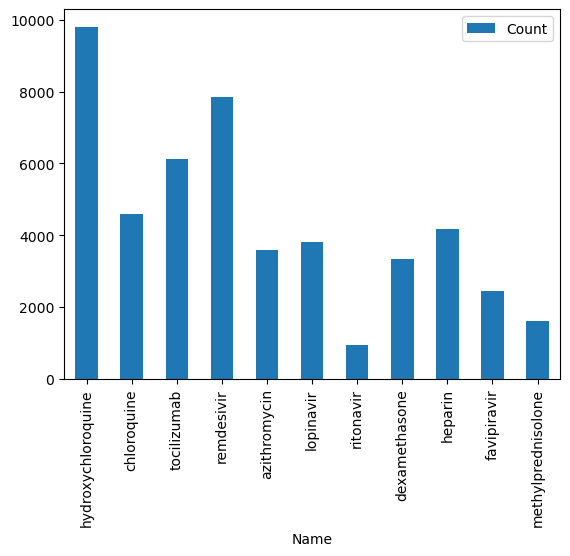

In [150]:
dfm.set_index('Name').plot(kind='bar')
plt.show()

## Mencari Tren dalam Strategi Pengobatan

Dalam contoh di atas, kita telah melakukan `sum` pada semua nilai, tetapi kita juga dapat melakukannya secara bulanan:


In [151]:
dfm = df[['publish_time']+medications].set_index('publish_time')
dfm = dfm[(dfm.index>="2020-01-01") & (dfm.index<="2021-07-31")]
dfmt = dfm.groupby([dfm.index.year,dfm.index.month]).sum()
dfmt

hydroxychloroquine  chloroquine  tocilizumab  \
publish_time publish_time                                                 
2020         1                           3672         1773         1779   
             2                              0           19            0   
             3                             45           72            5   
             4                            188          238           50   
             5                            459          191          158   
             6                            381          149          243   
             7                            381          178          202   
             8                            307          115          172   
             9                            319          123          185   
             10                           319           96          212   
             11                           272           66          170   
             12                           255          102          229   
2021         1                           2191          780         1787   
             2                            163           66          184   
             3                            172           85          190   
             4                            198           70          125   
             5                            141           55          138   
             6                            144           29          138   
             7                            112           49           96   

                           remdesivir  azithromycin  lopinavir  ritonavir  \
publish_time publish_time                                                   
2020         1                   2134          1173       1430        370   
             2                      3             3         18         11   
             3                     27            12         52         16   
             4                    124            68        113         13   
             5                    209           132        135         41   
             6                    186           110        132         18   
             7                    165           108        138         29   
             8                    165           145         91         24   
             9                    190            91         98         28   
             10                   227            72        127         39   
             11                   197            79        104         27   
             12                   271            98         76         31   
2021         1                   2523           892        841        198   
             2                    173            85         76          9   
             3                    295            87        100         17   
             4                    161            83         60         13   
             5                    179            69         55         21   
             6                    182            75         41         12   
             7                    270            64         59          5   

                           dexamethasone  heparin  favipiravir  \
publish_time publish_time                                        
2020         1                       561      984          666   
             2                         1        3           12   
             3                         3       21           11   
             4                        14       77           48   
             5                        12       92           48   
             6                        48       84           30   
             7                        58      117           56   
             8                        56       95           45   
             9                        90      111           46   
             10                       97      117           81   
             11                       77 

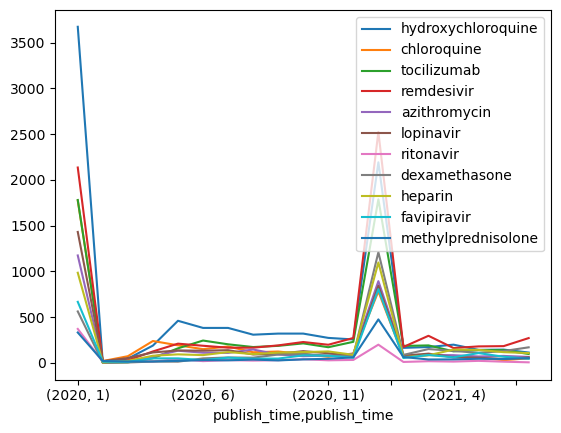

In [152]:
dfmt.plot()
plt.show()

Sebuah pengamatan menarik adalah adanya lonjakan besar di dua lokasi: Januari 2020 dan Januari 2021. Hal ini disebabkan oleh fakta bahwa beberapa makalah tidak memiliki tanggal publikasi yang jelas, sehingga ditetapkan sebagai Januari pada tahun yang bersangkutan.

Untuk memahami data dengan lebih baik, mari kita visualisasikan hanya beberapa obat. Kita juga akan "menghapus" data untuk bulan Januari, dan menggantinya dengan nilai rata-rata tertentu, agar plot terlihat lebih rapi:


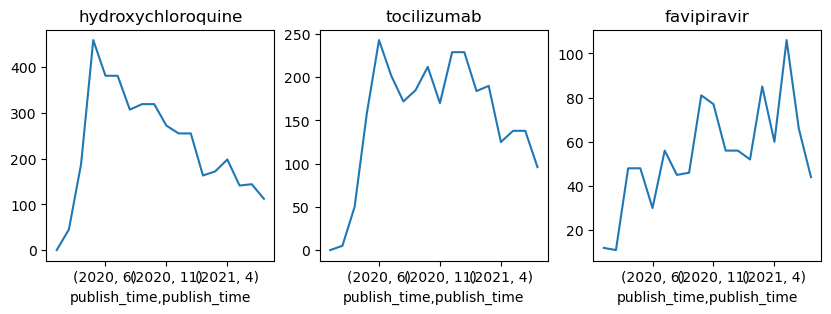

In [153]:
meds = ['hydroxychloroquine','tocilizumab','favipiravir']
dfmt.loc[(2020,1)] = np.nan
dfmt.loc[(2021,1)] = np.nan
dfmt.fillna(method='pad',inplace=True)
fig, ax = plt.subplots(1,len(meds),figsize=(10,3))
for i,m in enumerate(meds):
    dfmt[m].plot(ax=ax[i])
    ax[i].set_title(m)
plt.show()

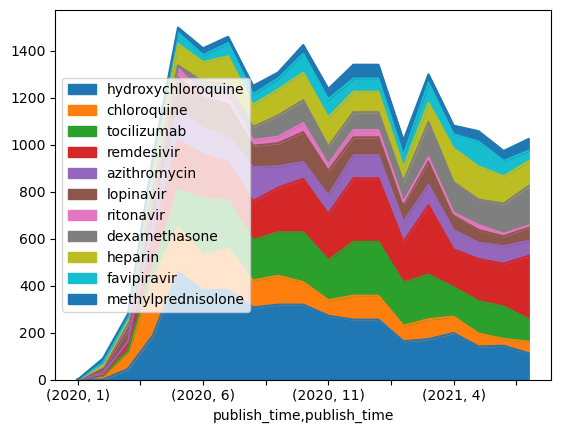

In [154]:
dfmt.plot.area()
plt.show()

Bahkan lebih jauh, kita dapat menghitung popularitas relatif dalam persen:


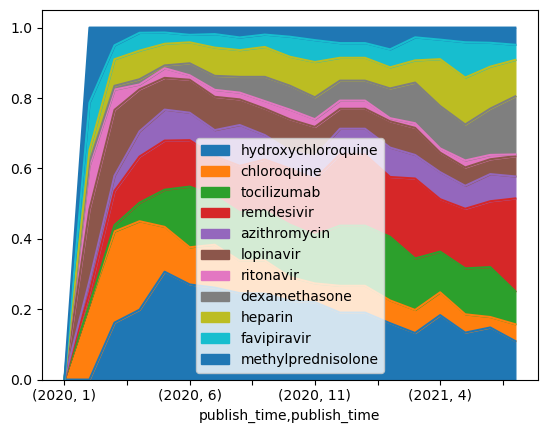

In [155]:
dfmtp = dfmt.iloc[:,:].apply(lambda x: x/x.sum(), axis=1)
dfmtp.plot.area()
plt.show()

## Hubungan Antara Obat dan Diagnosis

Salah satu hubungan paling menarik yang bisa kita telusuri adalah bagaimana berbagai diagnosis diobati dengan berbagai jenis obat. Untuk memvisualisasikannya, kita perlu menghitung **peta frekuensi kemunculan bersama**, yang akan menunjukkan seberapa sering dua istilah disebutkan dalam makalah yang sama.

Peta semacam ini pada dasarnya adalah matriks 2D, yang paling baik direpresentasikan dengan **numpy array**. Kita akan menghitung peta ini dengan menelusuri semua abstrak, dan menandai entitas yang muncul di sana:


In [156]:
m = np.zeros((len(medications),len(diagnosis)))
for a in df['abstract']:
    x = str(a).lower()
    for i,d in enumerate(diagnosis):
        if ' '+d in x:
            for j,me in enumerate(medications):
                if ' '+me in x:
                    m[j,i] += 1

In [157]:
m

array([[4788., 2264.,  741., 2109.,  348., 2730.,  975.],
       [2111., 1238.,  231.,  998.,   79., 1394.,  364.],
       [2186.,  821.,  691., 1063.,  185., 1136.,  573.],
       [3210., 2191.,  522., 1538.,  160., 2191.,  622.],
       [1803.,  773.,  406.,  880.,  133.,  909.,  410.],
       [1982., 1102.,  379.,  885.,  113., 1366.,  370.],
       [ 504.,  356.,   83.,  259.,   23.,  354.,  106.],
       [1419.,  640.,  345.,  742.,  108.,  760.,  314.],
       [1537.,  678.,  330.,  782.,   93.,  826.,  301.],
       [ 967.,  634.,  201.,  431.,   44.,  656.,  136.],
       [ 660.,  336.,  293.,  385.,   53.,  452.,  148.]])

Salah satu cara untuk memvisualisasikan matriks ini adalah dengan menggambar **heatmap**:


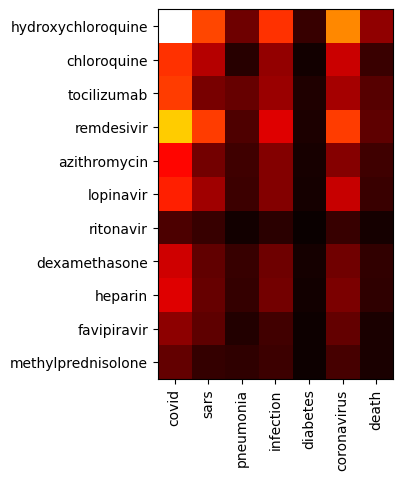

In [158]:
plt.imshow(m,interpolation='nearest',cmap='hot')
ax = plt.gca()
ax.set_yticks(range(len(medications))) 
ax.set_yticklabels(medications)
ax.set_xticks(range(len(diagnosis)))
ax.set_xticklabels(diagnosis,rotation=90)
plt.show()

Namun, visualisasi yang lebih baik dapat dilakukan menggunakan diagram **Sankey**! `matplotlib` tidak memiliki dukungan bawaan untuk jenis diagram ini, jadi kita harus menggunakan [Plotly](https://plotly.com/python/) seperti yang dijelaskan [dalam tutorial ini](https://plotly.com/python/sankey-diagram/).

Untuk membuat diagram sankey dengan plotly, kita perlu membangun daftar berikut:
* Daftar `all_nodes` yang berisi semua node dalam grafik, yang mencakup baik obat-obatan maupun diagnosis
* Daftar indeks sumber dan target - daftar ini akan menunjukkan node mana yang bergerak ke kiri, dan mana yang bergerak ke kanan dalam diagram
* Daftar semua tautan, setiap tautan terdiri dari:
   - Indeks sumber dalam array `all_nodes`
   - Indeks target
   - Nilai yang menunjukkan kekuatan tautan. Ini persis nilai dari matriks ko-occurence kita.
   - Opsional warna tautan. Kita akan membuat opsi untuk menyoroti beberapa istilah agar lebih jelas

Kode umum untuk menggambar diagram sankey disusun sebagai fungsi `sankey` terpisah, yang menerima dua daftar (kategori sumber dan target) dan matriks ko-occurence. Fungsi ini juga memungkinkan kita menentukan ambang batas, dan menghilangkan semua tautan yang lebih lemah dari ambang tersebut - ini membuat diagram menjadi sedikit lebih sederhana.


In [160]:
import plotly.graph_objects as go

def sankey(cat1, cat2, m, treshold=0, h1=[], h2=[]):
    all_nodes = cat1 + cat2
    source_indices = list(range(len(cat1)))
    target_indices = list(range(len(cat1),len(cat1)+len(cat2)))

    s, t, v, c = [], [], [], []
    for i in range(len(cat1)):
        for j in range(len(cat2)):
            if m[i,j]>treshold:
                s.append(i)
                t.append(len(cat1)+j)
                v.append(m[i,j])
                c.append('pink' if i in h1 or j in h2 else 'lightgray')

    fig = go.Figure(data=[go.Sankey(
        # Define nodes
        node = dict(
        pad = 40,
        thickness = 40,
        line = dict(color = "black", width = 1.0),
        label =  all_nodes),

        # Add links
        link = dict(
        source =  s,
        target =  t,
        value =  v,
        color = c
    ))])
    fig.show()

sankey(medications,diagnosis,m,500,h2=[0])

## Kesimpulan

Anda telah melihat bahwa kita dapat menggunakan metode yang cukup sederhana untuk mengekstrak informasi dari sumber data yang tidak terstruktur, seperti teks. Dalam contoh ini, kita telah menggunakan daftar obat yang sudah ada, tetapi akan jauh lebih kuat jika menggunakan teknik pemrosesan bahasa alami (NLP) untuk melakukan ekstraksi entitas dari teks. Dalam [blog post ini](https://soshnikov.com/science/analyzing-medical-papers-with-azure-and-text-analytics-for-health/) kami menjelaskan cara menggunakan layanan cloud untuk ekstraksi entitas. Pilihan lainnya adalah menggunakan pustaka NLP Python seperti [NLTK](https://www.nltk.org/) - pendekatan untuk mengekstrak informasi dari teks menggunakan NLTK dijelaskan [di sini](https://www.nltk.org/book/ch07.html).


## Tantangan

Lanjutkan penelitian data makalah COVID dengan langkah-langkah berikut:

1. Bangun matriks ko-occurence dari berbagai obat, dan lihat obat mana yang sering muncul bersama (yaitu disebutkan dalam satu abstrak). Anda dapat memodifikasi kode untuk membangun matriks ko-occurence untuk obat dan diagnosis.
1. Visualisasikan matriks ini menggunakan heatmap.
1. Sebagai tantangan tambahan, Anda dapat mencoba memvisualisasikan ko-occurence obat menggunakan [chord diagram](https://en.wikipedia.org/wiki/Chord_diagram). [Library ini](https://pypi.org/project/chord/) mungkin dapat membantu Anda menggambar chord diagram.
1. Sebagai tantangan tambahan lainnya, coba ekstrak dosis dari berbagai obat (seperti **400mg** dalam *minum 400mg chloroquine setiap hari*) menggunakan regular expressions, dan bangun dataframe yang menunjukkan berbagai dosis untuk berbagai obat. **Catatan**: pertimbangkan nilai numerik yang berada dalam jarak teks yang dekat dengan nama obat.



---

**Penafian**:  
Dokumen ini telah diterjemahkan menggunakan layanan penerjemahan AI [Co-op Translator](https://github.com/Azure/co-op-translator). Meskipun kami berusaha untuk memberikan hasil yang akurat, harap diketahui bahwa terjemahan otomatis mungkin mengandung kesalahan atau ketidakakuratan. Dokumen asli dalam bahasa aslinya harus dianggap sebagai sumber yang otoritatif. Untuk informasi yang bersifat kritis, disarankan menggunakan jasa penerjemahan profesional oleh manusia. Kami tidak bertanggung jawab atas kesalahpahaman atau penafsiran yang keliru yang timbul dari penggunaan terjemahan ini.
